[*********************100%***********************]  1 of 1 completed


Quarter 2020Q1: Portfolio Return = nan, SP500 Return = -0.20665776189333546
Quarter 2020Q2: Portfolio Return = 0.0006266978832665374, SP500 Return = 0.2549241202438778
Недостаточно данных для тикера PLTR в квартале 2020Q3, пропускаем.
Quarter 2020Q3: Portfolio Return = 7.175800890659031e-05, SP500 Return = 0.07931674852457143
Quarter 2020Q4: Portfolio Return = 2.5561973633190555e-05, SP500 Return = 0.11100035911953106
Quarter 2021Q1: Portfolio Return = 0.0004829019786031414, SP500 Return = 0.07356545401983472
Quarter 2021Q2: Portfolio Return = nan, SP500 Return = 0.06906439131589247
Quarter 2021Q3: Portfolio Return = -1.018896285059484e-05, SP500 Return = -0.002870387670184488
Quarter 2021Q4: Portfolio Return = 0.0005053756150337742, SP500 Return = 0.09390323087478082
Quarter 2022Q1: Portfolio Return = nan, SP500 Return = -0.05548766180189966
Quarter 2022Q2: Portfolio Return = nan, SP500 Return = -0.16729067840640108
Quarter 2022Q3: Portfolio Return = 0.0007204224703193639, SP500 Retur

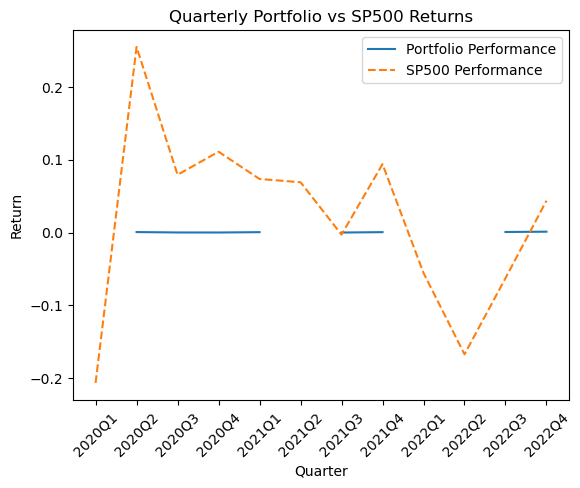

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Загрузка данных из CSV файла
data = pd.read_csv('sp500_historical_data.csv')

# Преобразуем столбец 'Date' в формат datetime
data['Date'] = pd.to_datetime(data['Date'])

# Удаление тикеров с пропусками
data = data.dropna()

# Добавим квартальные метки
data['Quarter'] = data['Date'].dt.to_period('Q')

# Загрузка данных по индексу S&P 500 с Yahoo Finance
sp500_data = yf.download('^GSPC', start='2010-01-01', end='2024-01-01')
sp500_data.reset_index(inplace=True)
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data['Quarter'] = sp500_data['Date'].dt.to_period('Q')

# Функция для включения акции в портфель
def include_in_portfolio(probability, expected_return, win_loss_ratio, min_kelly_fraction=0.01):
    """
    Функция для определения, следует ли включать актив в портфель.
    Возвращает оптимальную долю или None, если актив не удовлетворяет критериям.
    """
    # Расчет доли по критерию Келли
    kelly_fraction = kelly_criterion(probability, win_loss_ratio)
    
    # Условие включения в портфель: если доля по Келли положительная и больше минимума
    if kelly_fraction > min_kelly_fraction and expected_return > 0 and probability > 0.5:
        return kelly_fraction
    else:
        return None

# Функция для расчета критерия Келли
def kelly_criterion(probability, win_loss_ratio):
    return (probability * (win_loss_ratio + 1) - 1) / win_loss_ratio

# Функция для подготовки данных
def prepare_data(df, ticker):
    df_ticker = df[df['Ticker'] == ticker].copy()
    df_ticker['Target'] = df_ticker['Adj Close'].shift(-1)  # Целевая переменная - цена на следующий день
    df_ticker = df_ticker.dropna()
    
    # Выбор фич для модели
    X = df_ticker[['Open', 'High', 'Low', 'Close', 'Volume']]
    y = df_ticker['Target']
    
    return X, y, df_ticker

# Функция для предсказания цены
def predict_price(X_train, y_train, X_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

# Функция для получения квартальной доходности индекса
def get_quarterly_return(df, quarter):
    df_quarter = df[df['Quarter'] == quarter]
    if len(df_quarter) > 0:
        start_price = df_quarter.iloc[0]['Adj Close']
        end_price = df_quarter.iloc[-1]['Adj Close']
        return (end_price - start_price) / start_price
    else:
        return np.nan

# Основной цикл по кварталам
quarters = data['Quarter'].unique()
portfolio_performance = []
index_performance = []

for quarter in quarters:
    portfolio = {}
    quarterly_data = data[data['Quarter'] == quarter]
    
    tickers = quarterly_data['Ticker'].unique()

    # Создаем список для хранения акций, которые удовлетворяют критериям
    candidates = []

    # Фильтр для каждого тикера
    for ticker in tickers:
        X, y, df_ticker = prepare_data(quarterly_data, ticker)
        
        # Проверка на наличие достаточного количества данных
        if len(X) > 1:  # Должно быть хотя бы 2 строки данных для разделения
            # Разделение на обучающую и тестовую выборки
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Предсказание цены
            y_pred = predict_price(X_train, y_train, X_test)
            
            # Оценка вероятности того, что доходность будет положительной
            prob = (y_pred > X_test['Close']).mean()
            
            # Ожидаемая доходность
            expected_return = np.mean(y_pred - X_test['Close'])
            
            # Коэффициент выигрыша к проигрышу
            win_loss_ratio = expected_return / np.std(y_pred)
            
            # Проверка условий включения в портфель
            kelly_fraction = include_in_portfolio(prob, expected_return, win_loss_ratio)
            if kelly_fraction is not None:
                candidates.append((ticker, expected_return, kelly_fraction))
        else:
            print(f"Недостаточно данных для тикера {ticker} в квартале {quarter}, пропускаем.")
    
    # Сортировка акций по ожидаемой доходности от большего к меньшему
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Включаем первые 10 акций с наибольшей ожидаемой доходностью в портфель
    for candidate in candidates[:10]:
        ticker, expected_return, kelly_fraction = candidate
        portfolio[ticker] = kelly_fraction

    # Удаление акций с высокой корреляцией с SP500
    for ticker in list(portfolio.keys()):
        df_ticker = quarterly_data[quarterly_data['Ticker'] == ticker][['Date', 'Adj Close']]
        df_sp500 = sp500_data[sp500_data['Quarter'] == quarter][['Date', 'Adj Close']]

        # Объединение данных по дате, чтобы синхронизировать длины
        merged_df = pd.merge(df_ticker, df_sp500, on='Date', suffixes=('_ticker', '_sp500'))

        # Проверяем, что есть достаточно данных для вычисления корреляции
        if len(merged_df) > 1:
            correlation, _ = pearsonr(merged_df['Adj Close_ticker'], merged_df['Adj Close_sp500'])
            if correlation > 0.9:
                del portfolio[ticker]

    # Формируем DataFrame с тикерами и их долями
    portfolio_df = pd.DataFrame.from_dict(portfolio, orient='index', columns=['Kelly Fraction'])
    portfolio_df = portfolio_df[portfolio_df['Kelly Fraction'] > 0]  # Убираем активы с отрицательной долей

    # Оценка доходности портфеля
    portfolio_returns = []
    for ticker in portfolio_df.index:
        ticker_data = quarterly_data[quarterly_data['Ticker'] == ticker]['Adj Close'].pct_change().mean()
        if not np.isnan(ticker_data):  # Проверка на наличие данных
            portfolio_returns.append(ticker_data * portfolio_df.loc[ticker, 'Kelly Fraction'])
        else:
            print(f"Предупреждение: Пустые данные для тикера {ticker} в квартале {quarter}, пропускаем.")
        
    # Если портфель не пустой, вычисляем среднюю доходность
    if portfolio_returns:
        portfolio_performance.append(np.mean(portfolio_returns))
    else:
        portfolio_performance.append(np.nan)  # Добавляем NaN, если данных нет

    # Оценка доходности индекса SP500 за квартал
    sp500_return = get_quarterly_return(sp500_data, quarter)
    if not np.isnan(sp500_return):
        index_performance.append(sp500_return)
    else:
        print(f"Предупреждение: Пустые данные для индекса SP500 в квартале {quarter}, пропускаем.")
        index_performance.append(np.nan)

    print(f"Quarter {quarter}: Portfolio Return = {portfolio_performance[-1]}, SP500 Return = {sp500_return}")

# Визуализация результатов
# Преобразуем кварталы в строки для корректного отображения на графике
quarters_str = [str(q) for q in quarters]

# Визуализация результатов
plt.plot(quarters_str, portfolio_performance, label='Portfolio Performance')
plt.plot(quarters_str, index_performance, label='SP500 Performance', linestyle='--')
plt.title('Quarterly Portfolio vs SP500 Returns')
plt.xlabel('Quarter')
plt.ylabel('Return')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [2]:
# Вывод статистики ошибок
mean_error = np.mean(differences)
std_error = np.std(differences)
print(f'Средняя ошибка предсказания: {mean_error}')
print(f'Стандартное отклонение ошибки предсказания: {std_error}')

NameError: name 'differences' is not defined